# Landsat Downloader

**landsatxplorer** is a Python library designed for searching and downloading Landsat imagery from the USGS EarthExplorer platform. It allows users to query Landsat datasets by various parameters like location, date, and cloud cover, and download the corresponding images. This tool simplifies the process of accessing and working with satellite imagery for analysis and visualization in Python

**Information on Library:**
* Author: [Author Name]
* Notebook Version: 1.3 (Updated: January 10, 2024)

While the library is open-source, it has several limitations:
* Downloads satellite images as **.tar** files, with each band stored as a separate GeoTIFF.
* Lacks functionality to filter or clip images by bounding box, requiring additional post-processing.
* Outdated (last updated 3 years ago); installing it may disrupt other libraries. Use `pip install --upgrade libraryName` if issues arise.

## 1. Specifying the Paths and Working Directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\landsatxplorer\download"
working_folder = r".\data\landsatxplorer\working"
geotiff_folder = r".\data\landsatxplorer\geotiff"
csv_folder = r".\data\landsatxplorer\csv"
output_folder = r".\data\landsatxplorer\output"
''' ----- Ende der Eingaben ---- '''

# Create directories if they do not exist
os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 Authentication

To authenticate with the USGS API, follow these steps:

1. **Register**: Create an account at the [USGS registration page](https://ers.cr.usgs.gov/register/).
2. **Obtain Credentials**: After registering, SAVE your credentials as a `.json` file.

#### Example Format of the Credentials File:
The `*.json` file should have the following format:

```json
{
    "username": "your_username",
    "password": "your_password"
}
```

####  Important Security Note:
- **Keep the credentials file private**: Ensure that the `.json` file containing your username and password is stored securely and cannot be accessed by unauthorized users.
- **Permissions**: Never upload the credentials file to public repositories or share it with others.

In [2]:
import json
from landsatxplore.api import API

# Load credentials from the local JSON file
with open(r"D:/usgs.json", "r") as file:
    credentials = json.load(file)

username = credentials["username"]
password = credentials["password"]

In [3]:
pip insta

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "insta" - maybe you meant "install"



### 2.2 Search for Available Scenes

In [4]:
# Authenticate with the USGS API
api = API(username=username, password=password)

# Search for available scenes
scenes = api.search(
    dataset='landsat_ot_c2_l2',
    latitude=47.6780,
    longitude=9.1737,
    start_date='2020-01-01',
    end_date='2020-10-01',
    max_cloud_cover=10
)

# Output the number of scenes found
print(f"{len(scenes)} scenes found.")

8 scenes found.


In [5]:
import pandas as pd

# Collect scene information
rows = []
for scene in scenes:
    rows.append({
        "entity_id": scene["entity_id"],
        "display_id": scene["display_id"],
        "acq_date": scene["acquisition_date"],
        "scene_cloud_cover": scene["scene_cloud_cover"],
        "land_cloud_cover": scene["land_cloud_cover"],
        # "image_quality": scene["image_quality"],
        # "day-night": scene["day-night_indicator"],
        "sun-azumith": scene["sun_azimuth_l0ra"], # recommended: 90-270
        "sun-elevation": scene["sun_elevation_l0ra"] # recommended: 50-90
    })

# Create DataFrame
df = pd.DataFrame(rows)
pd.set_option('display.max_colwidth', 15)

# Display the DataFrame with styled width
df


,entity_id,display_id,acq_date,scene_cloud_cover,land_cloud_cover,sun-azumith,sun-elevation
0,LC819502720...,LC08_L2SP_1...,2020-09-12,9.18,9.18,156.215019,44.101558
1,LC819402720...,LC08_L2SP_1...,2020-08-20,5.51,5.51,149.829906,51.441079
2,LC819502720...,LC08_L2SP_1...,2020-08-11,8.02,8.02,147.421532,53.924649
3,LC819502720...,LC08_L2SP_1...,2020-06-24,3.12,3.12,141.817662,61.728886
4,LC819402720...,LC08_L2SP_1...,2020-06-01,5.08,5.08,144.886824,61.052324
5,LC819502720...,LC08_L2SP_1...,2020-05-07,1.80,1.80,149.179967,56.408805
6,LC819502720...,LC08_L2SP_1...,2020-04-05,2.01,2.01,152.809102,45.887567
7,LC819502720...,LC08_L2SP_1...,2020-01-16,1.56,1.56,159.999515,19.169424


In [6]:
list = df['display_id'].unique()
list

array(['LC08_L2SP_195027_20200912_20200919_02_T1',
       'LC08_L2SP_194027_20200820_20200905_02_T1',
       'LC08_L2SP_195027_20200811_20200918_02_T1',
       'LC08_L2SP_195027_20200624_20200824_02_T1',
       'LC08_L2SP_194027_20200601_20200824_02_T1',
       'LC08_L2SP_195027_20200507_20200820_02_T1',
       'LC08_L2SP_195027_20200405_20200822_02_T1',
       'LC08_L2SP_195027_20200116_20200823_02_T1'], dtype=object)

### 2.3 Visualizing Scene Polygons on a Map

In [7]:
import folium
from shapely import wkt
from matplotlib import pyplot as plt

# Define color map
cmap = plt.get_cmap("turbo", 20)

# Initialize folium map
m = folium.Map(location=[47.5, 8.0],
               zoom_start=7,
               height=450,
               scrollWheelZoom=False)

# Loop through scenes to add polygons
for i, scene in enumerate(scenes):
    entity_id = scene['entity_id']
    entity_cc = scene['cloud_cover']
    polygon_wkt = scene["spatial_coverage"]

    # Parse polygon from WKT string
    polygon = wkt.loads(polygon_wkt) if isinstance(polygon_wkt, str) else polygon_wkt

    # Generate color based on the index
    color = [int(c * 255) for c in cmap(i)[:3]]

    # Create feature group for each scene
    polygon_fg = folium.FeatureGroup(name=f"ID: {entity_id} (CC: {entity_cc})")

    # Add polygon to the map
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in polygon.exterior.coords],
        color=f"rgb({color[0]}, {color[1]}, {color[2]})",
        fill=True,
        fill_opacity=0.2,
    ).add_to(polygon_fg)

    # Add feature group to the map
    polygon_fg.add_to(m)

# Add layer control and display the map
folium.LayerControl().add_to(m)
m


### 2.4 Download Scenes Using Display ID

In [8]:
from landsatxplore.earthexplorer import EarthExplorer

# Initialize EarthExplorer
ee = EarthExplorer(username, password)

# Define the scene identifier and download path
identifier = 'LC08_L2SP_195027_20200624_20200824_02_T1'
download_filename = f"{identifier}.tar"
download_filepath = os.path.join(download_folder, download_filename)

# Check if the scene is already downloaded
if not os.path.isfile(download_filepath):
    ee.download(identifier=identifier, output_dir=download_folder)
else:
    print(f"The dataset {identifier} is already downloaded. Skipping download.")

# Logout from the API and EarthExplorer
api.logout()
ee.logout()

The dataset LC08_L2SP_195027_20200624_20200824_02_T1 is already downloaded. Skipping download.


### 2.5 Extract the TAR File

In [9]:
import os
import tarfile

# Define extraction folder path
extract_folder = os.path.join(working_folder, identifier)
os.makedirs(extract_folder, exist_ok=True)

# Check if the folder is empty before extracting
if not os.listdir(extract_folder):
    with tarfile.open(download_filepath) as tar:
        tar.extractall(path=extract_folder)
else:
    print(f"'{extract_folder}' is not empty. Skipping extraction.")

'.\data\landsatxplorer\working\LC08_L2SP_195027_20200624_20200824_02_T1' is not empty. Skipping extraction.


## 3. Merge RGB Bands into a Single GeoTIFF File

In [10]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        bandname=filename.replace(f"{identifier}_","").replace(".TIF", "")
    )

# Create DataFrame from the list of files inside the extracted directory
file_list = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.TIF')]
df_files = pd.DataFrame.from_dict(file_list)
# df_files

In [11]:
band_descriptions = {
    'QA_PIXEL': 'Quality Assessment Pixel (general quality information about each pixel)',
    'QA_RADSAT': 'Quality Assessment for Rad Saturation',
    'SR_B1': 'Band 1: Coastal/Aerosol (430–450 nm)',
    'SR_B2': 'Band 2: Blue (450–515 nm)',
    'SR_B3': 'Band 3: Green (525–600 nm)',
    'SR_B4': 'Band 4: Red (630–680 nm)',
    'SR_B5': 'Band 5: Near Infrared (NIR) (850–880 nm)',
    'SR_B6': 'Band 6: Shortwave Infrared 1 (SWIR1) (1570–1650 nm)',
    'SR_B7': 'Band 7: Shortwave Infrared 2 (SWIR2) (2110–2290 nm)',
    'SR_QA_AEROSOL': 'Quality Assessment for Aerosol (related to atmospheric conditions)',
    'ST_ATRAN': 'Atmospheric Transmission (fraction of incoming solar radiation)',
    'ST_B10': 'Band 10: Thermal Infrared 1 (TIR1) (10.60–11.19 µm)',
    'ST_CDIST': 'Cloud Distance (distance to the closest cloud)',
    'ST_DRAD': 'Radiance (measure of energy per unit area)',
    'ST_EMIS': 'Emissivity (related to surface temperature)',
    'ST_EMSD': 'Emissivity Standard Deviation',
    'ST_QA': 'Quality Assessment for thermal bands',
    'ST_TRAD': 'Radiant Temperature (measured in Kelvin)',
    'ST_URAD': 'Upwelling Radiance (energy coming from the surface)'
}

pd.reset_option('display.max_colwidth')

df_files['remarks'] = df_files['bandname'].map(band_descriptions)
df_files.loc[:, df_files.columns.isin(['bandname', 'remarks'])]


,bandname,remarks
0,QA_PIXEL,Quality Assessment Pixel (general quality info...
1,QA_RADSAT,Quality Assessment for Rad Saturation
2,SR_B1,Band 1: Coastal/Aerosol (430–450 nm)
3,SR_B2,Band 2: Blue (450–515 nm)
4,SR_B3,Band 3: Green (525–600 nm)
5,SR_B4,Band 4: Red (630–680 nm)
6,SR_B5,Band 5: Near Infrared (NIR) (850–880 nm)
7,SR_B6,Band 6: Shortwave Infrared 1 (SWIR1) (1570–165...
8,SR_B7,Band 7: Shortwave Infrared 2 (SWIR2) (2110–229...
9,SR_QA_AEROSOL,Quality Assessment for Aerosol (related to atm...


In [12]:
import rasterio

def apply_reflectance_correction(band_data, bandname):
    if bandname in ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']:
        # Apply the reflectance correction (for bands 1-7)
        return (band_data * 2.75e-5) - 0.2
    else:
        return band_data

def apply_thermal_correction(band_data, bandname, no_data_value):
    if bandname == 'ST_B10':
        # Apply the thermal correction (for band 10)
        corrected_data = (band_data * 0.00341802) + 149.0
        
        # Set values of 0 to NoData (cloud cover) using the NoData value
        corrected_data[band_data == 0] = no_data_value
        
        return corrected_data
    else:
        return band_data

def merge_tif(output_filename, bandname_list=None, file_list=None):
    stacked_data = []
    
    # Open the first file to determine the NoData value for the output
    with rasterio.open(file_list[0]['path']) as first_band:
        no_data_value = first_band.nodata  # Retrieve the NoData value from the input raster
    
    for bandname in bandname_list:
        for file in file_list:
            if file['bandname'] == bandname:
                with rasterio.open(file['path']) as band_data:
                    band_array = band_data.read(1)  # Read the first band as array
                    # Apply corrections based on bandname
                    if bandname in ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']:
                        band_array = apply_reflectance_correction(band_array, bandname)
                    elif bandname == 'ST_B10':
                        band_array = apply_thermal_correction(band_array, bandname, no_data_value)
                    stacked_data.append(band_array)

    # Write the merged bands into a new raster file
    output_filepath = os.path.join(geotiff_folder,output_filename)
    with rasterio.open(
        output_filepath,
        'w',
        driver='GTiff',
        height=stacked_data[0].shape[0],
        width=stacked_data[0].shape[1],
        count=len(bandname_list),
        dtype=stacked_data[0].dtype,
        crs=rasterio.open(file_list[0]['path']).crs,
        transform=rasterio.open(file_list[0]['path']).transform,
        nodata=no_data_value  # Set the NoData value for the output file
    ) as dest:
        for idx, band_data in enumerate(stacked_data, start=1):
            dest.write(band_data, idx)

In [13]:
if __name__ == "__main__":
    # Example usage
    bandname_list = ['SR_B1', 'SR_B2', 'SR_B3']
    merge_tif(output_filename="merged_rgb.tif", bandname_list=bandname_list, file_list=file_list)

    # Example usage
    bandname_list = ['ST_B10']
    merge_tif(output_filename="ST_B10_LST.tif", bandname_list=bandname_list, file_list=file_list)

## 4. Calculate Indices

* Normalized Vegetation Index: NDVI = (NIR-Red)/(NIR+Red)
* Normalized Difference Water Index: NDWI = (Green-NIR)/(Green+NIR)
* Enhanced Vegetation Index : EVI = G * (NIR-Red)/(NIR+C1 x Red-C2 x Blue+L), where G=2.5, C1,C2=6,7.5, L=10000
* Soil Adjusted Vegetation Index: SAVI = {(NIR-Red)*(1+L)}/{NIR + Red + L}, where L: 0.5 (Typically)
* Built-up Index: BUI = (SWIR-NIR)/(SWIR+NIR)

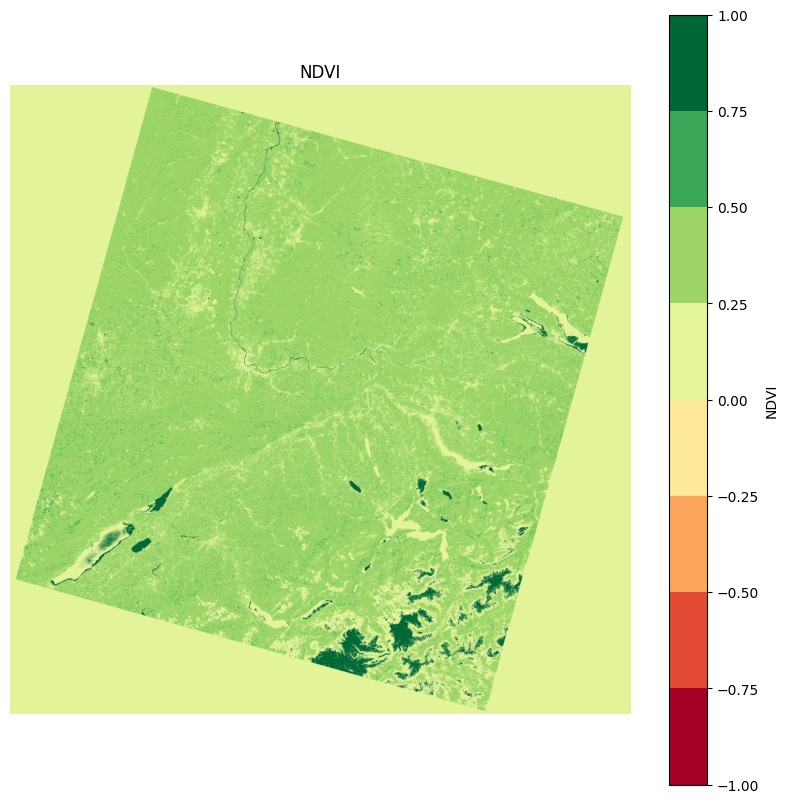

In [14]:
## NDVI
required_bandname_list = ['SR_B5', 'SR_B4']

stacked_data = []

for bandname in required_bandname_list:
    for file in file_list:
        if file['bandname'] == bandname:
            with rasterio.open(file['path']) as band_data:
                band_array = band_data.read(1)
                stacked_data.append(band_array)

ndvi = (stacked_data[0]-stacked_data[1])/(stacked_data[0]+stacked_data[1]+1e-10)

# Plot NDVI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('RdYlGn',8)
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI')
plt.axis('off')
plt.show()

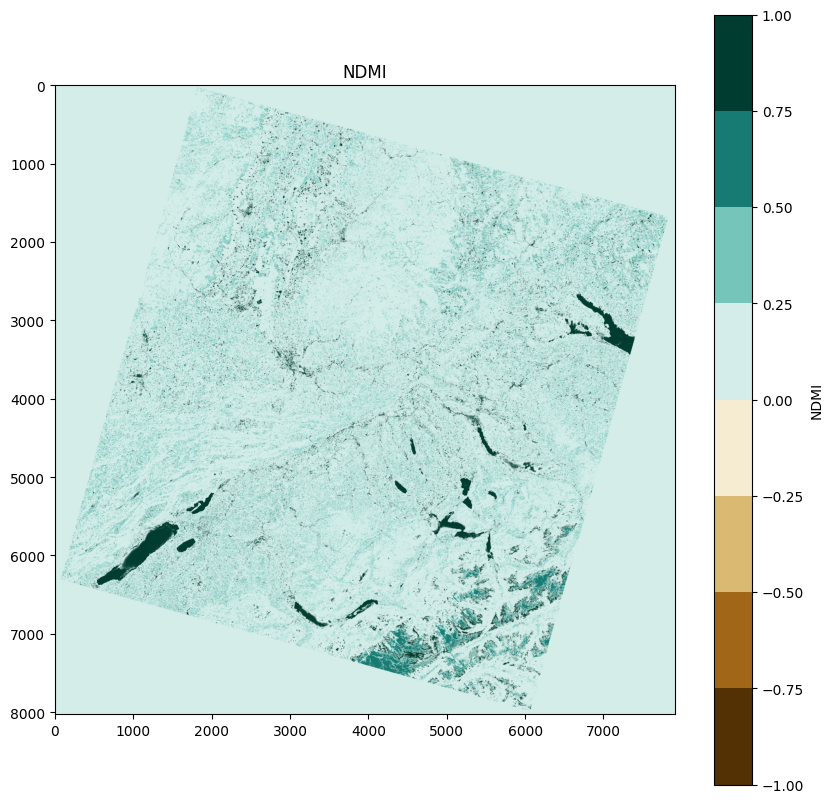

In [15]:
## NDMI (nir - swir)/(nir+swir)
required_bandname_list = ['SR_B5', 'SR_B6']

stacked_data = []

for bandname in required_bandname_list:
    for file in file_list:
        if file['bandname'] == bandname:
            with rasterio.open(file['path']) as band_data:
                band_array = band_data.read(1)
                stacked_data.append(band_array)

ndwi = (stacked_data[0]-stacked_data[1])/(stacked_data[0]+stacked_data[1]+1e-10)

# Plot NDVI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('BrBG',8)
plt.imshow(ndwi, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(label='NDMI')
plt.title('NDMI')
# plt.axis('off')
plt.show()